In [1]:
!pip -q install jupyterthemes
!pip -q install git+https://github.com/TimeSynth/TimeSynth.git

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
        Using cached meson_python-0.16.0-py3-none-any.whl (26 kB)
        Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
        Using cached setuptools_scm-8.1.0-py3-none-any.whl (43 kB)
        Using cached numpy-2.0.0.tar.gz (18.3 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'error'
        error: subprocess-exited-with-error
      
        Ã— Preparing metadata (pyproject.toml) did not run successfully.
        â”‚ exit code: 1
        â•°â”€> [2 lines of output]
      
            meson-python: error: Co

In [3]:
from utils import *
import pickle
from scipy.stats import norm
import seaborn as sb
from sklearn.metrics import mean_absolute_error


from keras.models import Model
from keras.layers import Activation
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam


<Axes: xlabel='TimeStamp'>

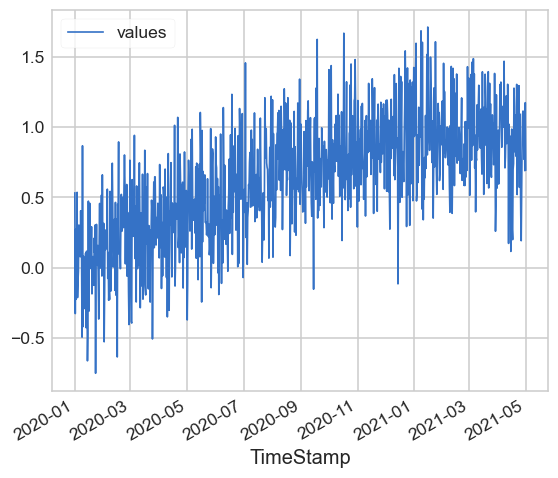

In [4]:
df = create_time_series(start_date='1/1/2020', end_date='05/01/2021', num_periods=1000)
df.plot()

In [5]:
X = df['values'].values.reshape((len(df), 1))
y = df['values'].values.reshape((len(df), 1))

X = X[:-1, :]
y = y[1:, :]

train_len = int(len(X) * 0.9)

X_train, X_val, y_train, y_val = X[:train_len, :], X[train_len:, :], y[:train_len, :], y[train_len:, :]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((17999, 1), (17999, 1), (2000, 1), (2000, 1))

In [6]:
X[1, :], y[0, :]

(array([-0.32631284]), array([-0.32631284]))

In [7]:
n_timesteps = 48
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]

In [8]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples + 1)]
X_train = np.concatenate(X_train_list, axis=0)
y_train = y_train[n_timesteps-1:, :]

X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val = np.concatenate(X_val_list, axis=0)
y_val = y_val[n_timesteps-1:, :]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((17952, 48, 1), (17952, 1), (1953, 48, 1), (1953, 1))

In [11]:
def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, n_features))

    x = LSTM(50, return_sequences=True)(i)
    x = Dropout(0.4)(x)

    x = LSTM(50)(x)
    x = Dropout(0.4)(x)

    x = Dense(n_features, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(learning_rate=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)

    return model

In [12]:
model = Autoencoder(n_timesteps, n_features)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=20, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.4605 - val_loss: 0.7733
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.6871 - val_loss: 0.7414
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.6858 - val_loss: 0.7416
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.6836 - val_loss: 0.7381
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - loss: 0.6693 - val_loss: 0.7615
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.6663 - val_loss: 0.7698
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - loss: 0.6654 - val_loss: 0.7721
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.6650 - val_loss: 0.7730
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.6650 - val_loss: 0.7737
Epoch 10/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.6649 - val_loss: 0.7735
Epoch 11/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.6649 - val_loss: 0.7737
Epoch 12/20
141/141 ━━━━━━━━━━

In [14]:
model.save('src/model/autoencoder_model.h5')

In [15]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

561/561 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step


(17952, 1)

In [16]:
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

17952

C:\Users\Asus\AppData\Local\Temp\ipykernel_9376\4284000984.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(errors, shade=True)


<Axes: ylabel='Density'>

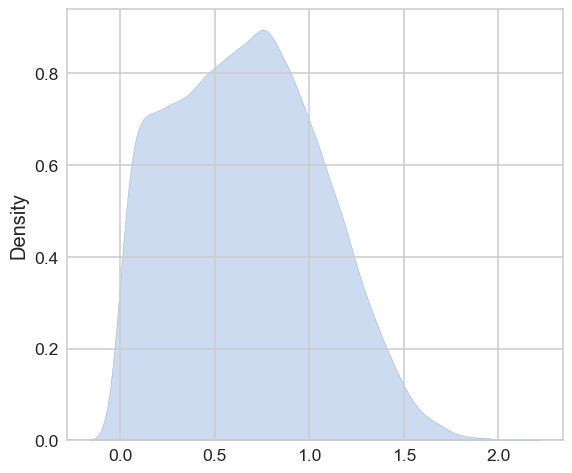

In [17]:
sb.kdeplot(errors, shade=True)

In [18]:
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(0.6654880594562591, 0.388524840202912)

In [19]:
def is_anomaly(error, mean, std, threshold):
    delta = np.abs(error - mean)
    multiple = delta / std
    if multiple < threshold:
        return 0
    else:
        return 1

In [26]:
y_val_pred = model.predict(X_val[:, :, :])
val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
val_result = [is_anomaly(x, dist.mean(), dist.std(), 2) for x in val_errors]
print(val_result)

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
train_errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
train_result = [is_anomaly(x, dist.mean(), dist.std(), 2) for x in train_errors]
print(train_result)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)

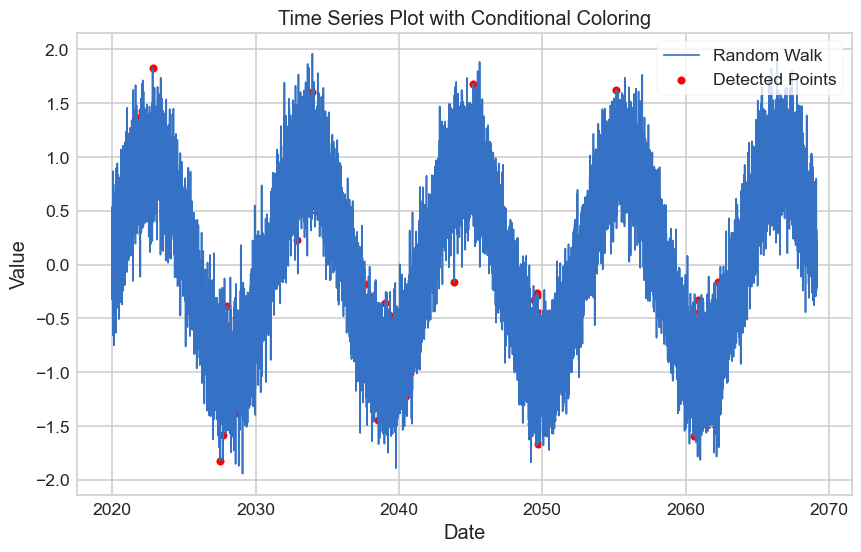

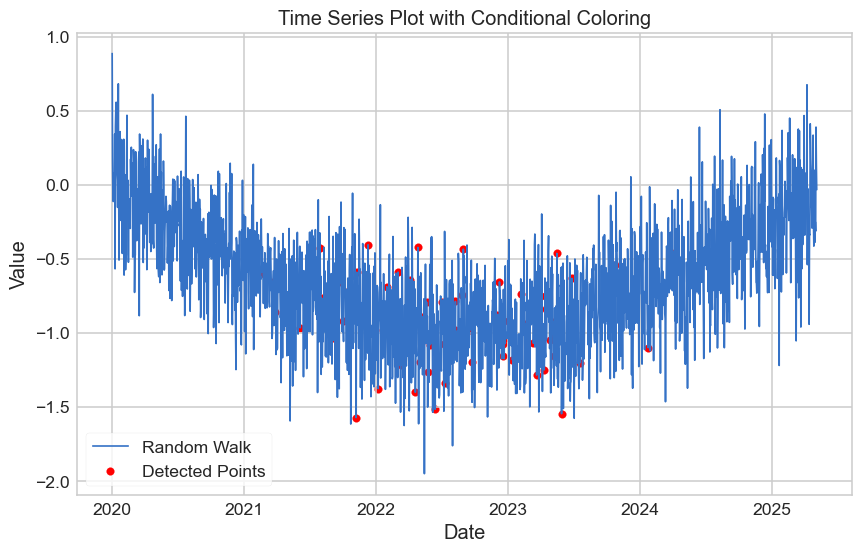

In [29]:
plot_series(X_train[:, 0, 0].reshape(-1), train_result)
plot_series(X_val[:, 0, 0].reshape(-1), val_result)

In [25]:
from tensorflow.keras.models import load_model

model = load_model('src/model/autoencoder_model.h5')

In [39]:
from tensorflow.keras.models import save_model

save_model(model, 'src/model/autoencoder_model.h5')

In [37]:
import tensorflow as tf
import keras

print(keras.__version__)
print(tf.__version__)


3.4.1
2.16.2
